<img src="header.png" align="left"/>

# Anwendungsbeispiel Import of sensor data and classification

Ziel dieses Beispieles ist der Import und die Vorverarbeitung von Sensordaten für die Klassifizierung. Der Verwendete Datensatz ist der HAR Datensatz [1].

Die Messungen der Daten wurden mit einer Gruppe von 30 Freiwilligen in einer Altersgruppe von 19-48 Jahren durchgeführt. Jede Person führte sechs Aktivitäten durch (WALKING, WALKING_UPSTAIRS, WALKING_DOWNNSTAIRS, SITTING, STANDING, LAYING) und trug ein Smartphone (Samsung Galaxy S II) auf der Hüfte. Mit Hilfe des integrierten Beschleunigungsmessers und Gyroskops haben wir die dreiachsige lineare Beschleunigung und die dreiachsige Winkelgeschwindigkeit bei einer konstanten Rate von 50 Hz erfasst. Die Experimente wurden auf Video aufgezeichnet, um die Daten manuell zu labeln. Der erhaltene Datensatz wurde nach dem Zufallsprinzip in zwei Sätze aufgeteilt, wobei 70% der Samples für die Erstellung der Trainingsdaten und 30% der Testdaten ausgewählt wurden.

Die Sensorsignale (Beschleunigungsmesser und Gyroskop) wurden durch Anwendung von Rauschfiltern vorverarbeitet und dann in windows mit fester Breite von 2,56 s und 50% Überlappung abgetastet (128 Messungen/Fenster). Das Sensorbeschleunigungssignal, das eine Schwerkraft- und eine Körperbewegungskomponente aufweist, wurde mit einem Butterworth-Tiefpassfilter in Körperbeschleunigung und Schwerkraft getrennt. Es wird angenommen, dass die Gravitationskraft nur niederfrequente Komponenten aufweist, daher wurde ein Filter mit einer Grenzfrequenz von 0,3 Hz verwendet. Aus jedem Fenster wurde ein Vektor von Merkmalen durch Berechnung von Variablen aus dem Zeit- und Frequenzbereich gewonnen (Übersetzt mit www.DeepL.com/Translator).




Der Beispielcode wurde im Wesentlichen von [2] übernommen. Eine Übersicht zu anderen Methoden für die Klassifizierung von Zeitreihen ist in [3] gegeben. 


Quellen

- [1] [https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)
- [2] [https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/](https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/)
- [3] [https://www.mdpi.com/1424-8220/18/2/679/pdf](https://www.mdpi.com/1424-8220/18/2/679/pdf)
- [4] [https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/](https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/)


Zitierung für HAR Datensatz
```
Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.
```



In [2]:
import os
import numpy as np
import pandas as pd
import zipfile
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
#
# Abdrehen von Fehlermeldungen
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

In [4]:
#
# Für GPU Support
#
import tensorflow as tf
print ( tf.__version__ ) 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2.0.0


In [5]:
urlDataSource = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
localExtractionFolder = 'data/UCIHAR'
localDataArchive = localExtractionFolder + '/UCI HAR Dataset.zip'
sensorData = localExtractionFolder + '/UCI HAR Dataset'

In [6]:
#
# Laden der Daten von einer URL
#
def download_dataset(url,extraction_path,dataset_file_path):
    if (not os.path.exists(extraction_path)):
        os.makedirs(extraction_path)
    if os.path.exists(localDataArchive):
        print("archive already downloaded.")
    else:
        print("started loading archive from url {}".format(url))
        filename, headers = urlretrieve(url, dataset_file_path)
        print("finished loading archive from url {}".format(url))

def extract_dataset(dataset_file_path, extraction_directory):  
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)        
    zip = zipfile.ZipFile(dataset_file_path)
    zip.extractall(path=extraction_directory)        
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )


In [7]:
#
# Laden der Daten ausführen
#
download_dataset(urlDataSource,localExtractionFolder,localDataArchive)

archive already downloaded.


In [8]:
#
# Extrahieren der Daten
#
extract_dataset(localDataArchive,localExtractionFolder)

extraction of dataset from data/UCIHAR/UCI HAR Dataset.zip to data/UCIHAR done.


In [9]:
#
# Laden eines Files
#
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

#
# Laden einer Gruppe (test, train)
#
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

#
# Laden aller Daten
#
def load_dataset ( group, prefix=''):
    filepath = os.path.join( prefix, group, 'Inertial Signals/')
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    x = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + '/' + group + '/y_'+group+'.txt')
    return x, y

In [10]:
x_train, y_train = load_dataset('train', sensorData )
print(x_train.shape, y_train.shape)

(7352, 128, 9) (7352, 1)


In [11]:
x_test, y_test = load_dataset('test', sensorData )
print(x_test.shape, y_test.shape)

(2947, 128, 9) (2947, 1)


# Was sind sliding windows?

Zeitreihendaten werden oft in kleinere Einheiten unterteilt. Diese Einheiten haben eine fixe Länge und werden **sliding windows** genannt. Eine gute Übersicht dazu wird in [https://datasciencetips.com/time-series-as-supervised-learning/](https://datasciencetips.com/time-series-as-supervised-learning/) gegeben.

In unserem HAR Datensatz wurde das bereits im preprocessing Schritt vorbereitet. Daher brauchen wir diese Transformation nicht durchführen.

# Überprüfen der Klassenverteilung

In [12]:
# summarize the balance of classes in an output variable column
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [13]:
# summarize combined class breakdown
combined = np.vstack((y_train, y_test))
class_breakdown(combined)

Class=1, total=1722, percentage=16.720
Class=2, total=1544, percentage=14.992
Class=3, total=1406, percentage=13.652
Class=4, total=1777, percentage=17.254
Class=5, total=1906, percentage=18.507
Class=6, total=1944, percentage=18.876


# Umwandlung der Klassennummer in one-hot encoding

In [14]:
# convert class vectors to binary class matrices
y_train_oh = np_utils.to_categorical(y_train, 7 )
y_test_oh = np_utils.to_categorical(y_test, 7 )

print(y_train.shape)
print(y_test.shape)

(7352, 1)
(2947, 1)


# Überprüfen eines Datensatzes

In [15]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    return X[ix, :, :], y[ix]
 
# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series
 
# plot the data for one subject
def plot_subject(X, y):
    plt.figure(figsize=(20, 10))
    # determine the total number of plots
    n, off = X.shape[2] + 1, 0
    # plot total acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('total acc '+str(i), y=0, loc='left')
        off += 1
    # plot body acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('body acc '+str(i), y=0, loc='left')
        off += 1
    # plot body gyro
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('body gyro '+str(i), y=0, loc='left')
        off += 1
    # plot activities
    plt.subplot(n, 1, n)
    plt.plot(y)
    plt.title('activity', y=0, loc='left')
    plt.show()

In [16]:
sub_map = load_file( sensorData + '/train/subject_train.txt')
train_subjects = np.unique(sub_map)
print(train_subjects)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]


(347, 128, 9) (347, 1)


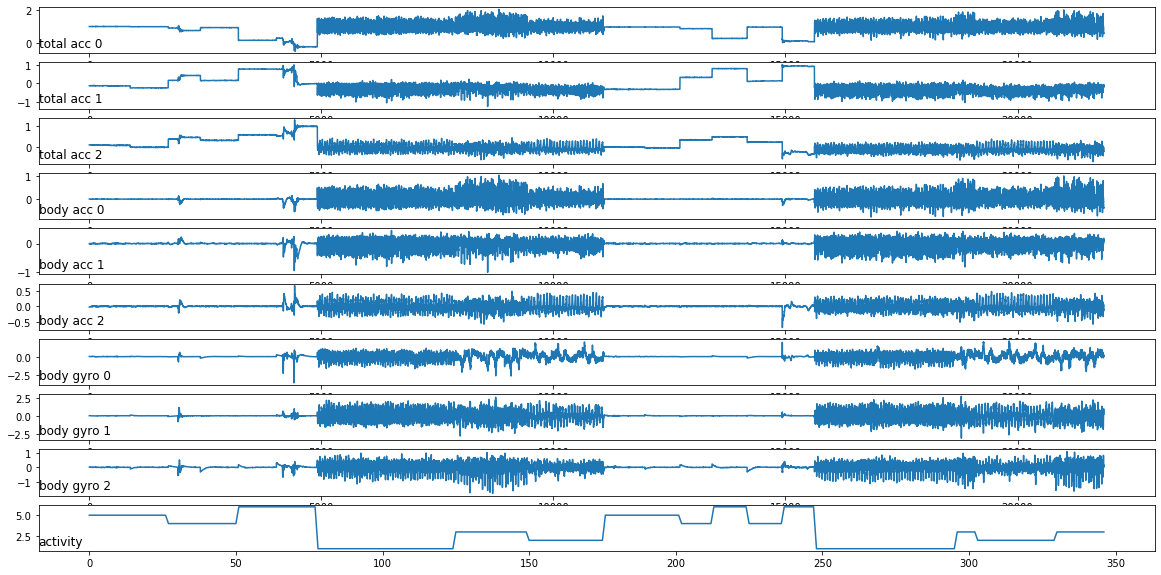

In [17]:
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(x_train, y_train, sub_map, sub_id)
print(subX.shape, suby.shape)
# plot data for subject
plot_subject(subX, suby)

# Bauen eines LSTM Modelles

Wir verwenden eine neue Form eines Neuronalen Netzwerkes. Ein RNN ist ein Modell für die Analyse von Zeitreihen. Details dazu sind zu finden unter [https://medium.com/@purnasaigudikandula/recurrent-neural-networks-and-lstm-explained-7f51c7f6bbb9](https://medium.com/@purnasaigudikandula/recurrent-neural-networks-and-lstm-explained-7f51c7f6bbb9). 


In [18]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(trainX, trainy, epochs=15, batch_size=64, verbose=1)

    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [19]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [20]:
# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(x_train, y_train_oh, x_test, y_test_oh)
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

In [21]:
 
# run the experiment
run_experiment()

ValueError: You are passing a target array of shape (7352, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

In [ ]:
# fit and evaluate a model
def evaluate_model(x_train, y_train_oh, x_test, y_test_oh):
    n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 32
    x_train = x_train.reshape((x_train.shape[0], n_steps, n_length, n_features))
    x_test = x_test.reshape((x_test.shape[0], n_steps, n_length, n_features))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=30, batch_size=64, verbose=1)
    # evaluate model
    _, accuracy = model.evaluate(x_test, y_test, batch_size=64, verbose=0)
    return accuracy